In [1]:
%load_ext autoreload
%autoreload 2

import sys,glob,os,errno
import numpy as np
import matplotlib.pyplot as plt

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from dustextinction import (
    get_gal_extinction_from_radec,
    get_xredden_template_model,
)
from utils import (
    get_dataset_energy_edges
)

from gammapy.datasets import Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import Models

## Datasets and models

In [2]:
basedir = os.path.abspath("../../../")
datasetdir  = f"{basedir}/Liverpool_IOO/MJD60373/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
liverpool_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
liverpool_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))

# Stack datasets ?
unique_bands = np.unique([d.name.split('_h_e_')[0] for d in liverpool_datasets])
liverpool_datasets = Datasets([Datasets([d for d in liverpool_datasets if band in d.name]).stack_reduce(name=band) for band in unique_bands])
liverpool_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))

extinction_model = get_xredden_template_model(f"{basedir}/Models/xredden_tau_factor_vs_EBV_energy.ecsv",
                                              srcname='OP313')

extinction_model.parameters['ebv'].frozen = True
#liverpool_datasets.models[0].spectral_model.parameters['beta'].prior = UniformPrior(max=0,weight=10)
liverpool_datasets.models[0].spectral_model *= extinction_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


## Fit and flux points

In [3]:
# Define a fit
liverpool_only_fit     = Fit(store_trace=True)
liverpool_only_fit.optimize_opts = {"tol": 0.1, "strategy": 1, 'migrad_opts':{'ncall':10000, 'iterate': 10}}
liverpool_only_result  = liverpool_only_fit.run(liverpool_datasets)
# we make a copy here for later comparisons
liverpool_only_model   = liverpool_datasets.models.copy()
energy_edge_pairs      = [get_dataset_energy_edges(d) for d in liverpool_datasets]
# correct the systematic uncertainty?
#liverpool_datasets.models[0].spectral_model.model1 = liverpool_datasets.models[0].spectral_model.model1.model2
liverpool_only_fpe     = [FluxPointsEstimator(energy_edges=energy_edge_pairs[k], source='OP313') for k,d in enumerate(liverpool_datasets)]
    
liverpool_only_points  = [liverpool_only_fpe[k].run(datasets=d) for k,d in enumerate(liverpool_datasets)]

In [4]:
liverpool_only_result

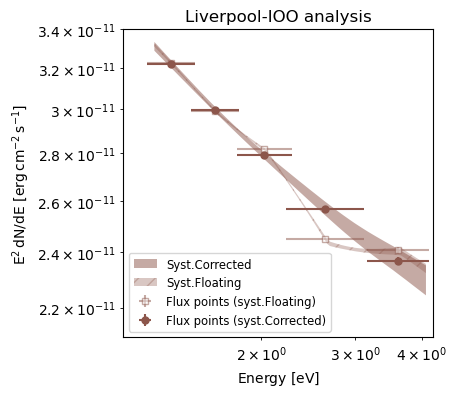

In [5]:
fig = plt.figure(figsize=(4, 4),dpi=100)

emin = min([min(pair) for pair in energy_edge_pairs])
emax = max([max(pair) for pair in energy_edge_pairs])

systematic_model = liverpool_only_model[0].spectral_model.model1.model1
intrinsic_model  = liverpool_only_model[0].spectral_model.model1.model2
absorption_model = liverpool_only_model[0].spectral_model.model2
corrected_model = (intrinsic_model * absorption_model)
ax = corrected_model.plot_error(
    [emin,emax],
    facecolor='C5',alpha=0.5,label='Syst.Corrected',
    sed_type='e2dnde')
ax = (liverpool_only_model[0].spectral_model).plot_error(
    [emin,emax],
    ax=ax,
    facecolor='C5',label='Syst.Floating',
    hatch='//',edgecolor='C5',alpha=0.33,
    sed_type='e2dnde')

for k,point in enumerate(liverpool_only_points):
    point.plot(
        ax=ax, color="C5", mfc='white', sed_type='e2dnde',marker='s',
        alpha=0.5,label='Flux points (syst.Floating)' if k==0 else '',
    )
    point_corr = point.from_table(point.to_table().copy(),reference_model=corrected_model)
    point_corr.plot(
        ax=ax, color="C5", markersize=5,sed_type='e2dnde',zorder=10,
        label='Flux points (syst.Corrected)' if k==0 else '',
    )

#ax.set_xlim(emin,emax)
ax.set_xlim(1.1,4.2)
ax.set_ylim(2.1e-11,3.4e-11)
ax.legend(loc=3,fontsize='small',)
ax.set_title('Liverpool-IOO analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

!mkdir -p {basedir}/Figures/MJD60373/LiverpoolTelescope/
fig.savefig(f'{basedir}/Figures/MJD60373/Liverpool/BestFit_LiverpoolTelescope.pdf',bbox_inches='tight')